In [147]:
df = pd.read_csv('train.csv')
df['Date'] = pd.to_datetime(df['Date'])

# PCA: Dept
- 가정: 동일한 Dept는 동일한 판매 추이를 가진다
- 강동, 왕십리, 강남, 서초 등의 모든 수산물 코너는, 10~ 12월에 잘 팔리고, 6~8월에 안팔린다
- 강동 지점은 특이하게 수산물 코너가 6월에 잘팔린다면, PCA를 적용했을 때, 그것은 약화될 것

In [148]:
c = df['Dept'] == 1
df_pivot = df[c].pivot(index='Date', columns='Store', values='Weekly_Sales').fillna(0)

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
df_low = pca.fit_transform(df_pivot)
df_inverse = pca.inverse_transform(df_low)

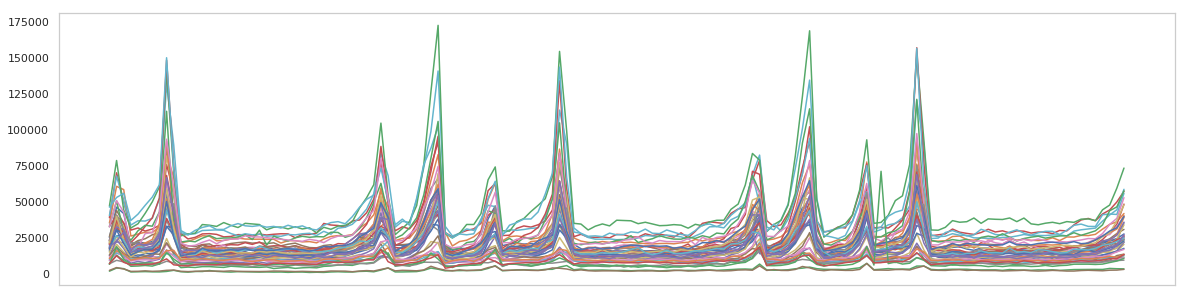

In [32]:
plt.figure(figsize=(20, 5))
plt.plot(df_pivot)
plt.grid(False)
plt.xticks([])
plt.show()

[0.92198123 0.94845318 0.96308582 0.97236627 0.97740832 0.98192316
 0.98523051 0.98752248 0.98917552 0.99052407 0.9916977  0.99282325]


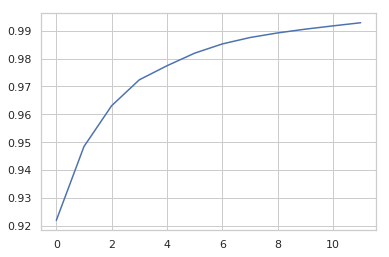

In [81]:
# component1이 가장 강하다 = 분산을 가장 잘 설명한다 = 대표적 패턴이다
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_))
plt.show()

# components

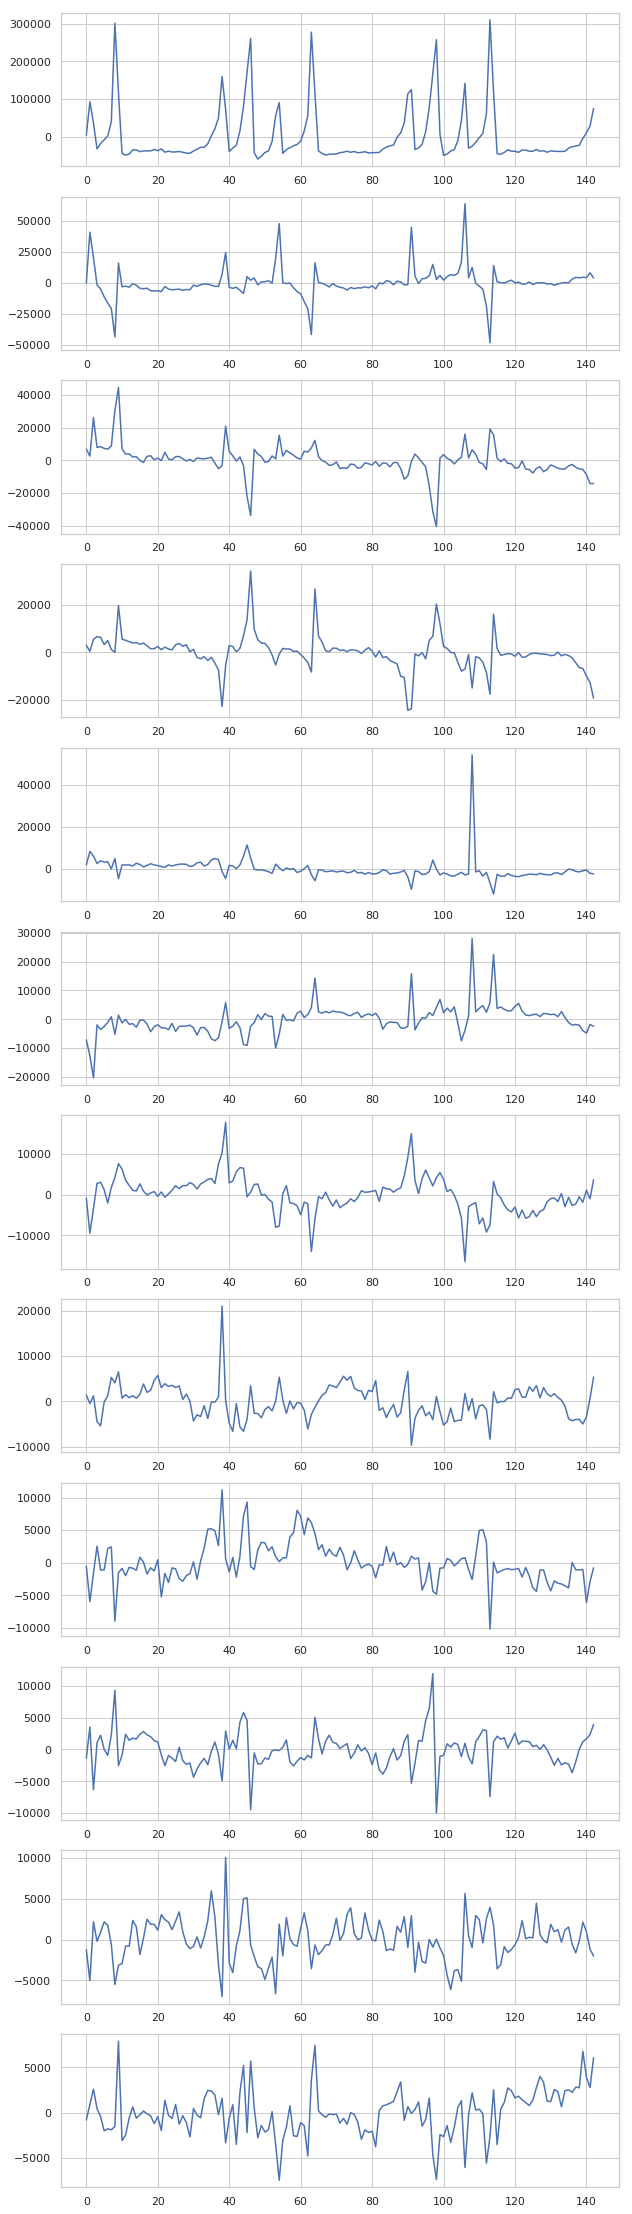

In [27]:
plt.figure(figsize=(10, 40))
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(df_low[:, i])
plt.show()

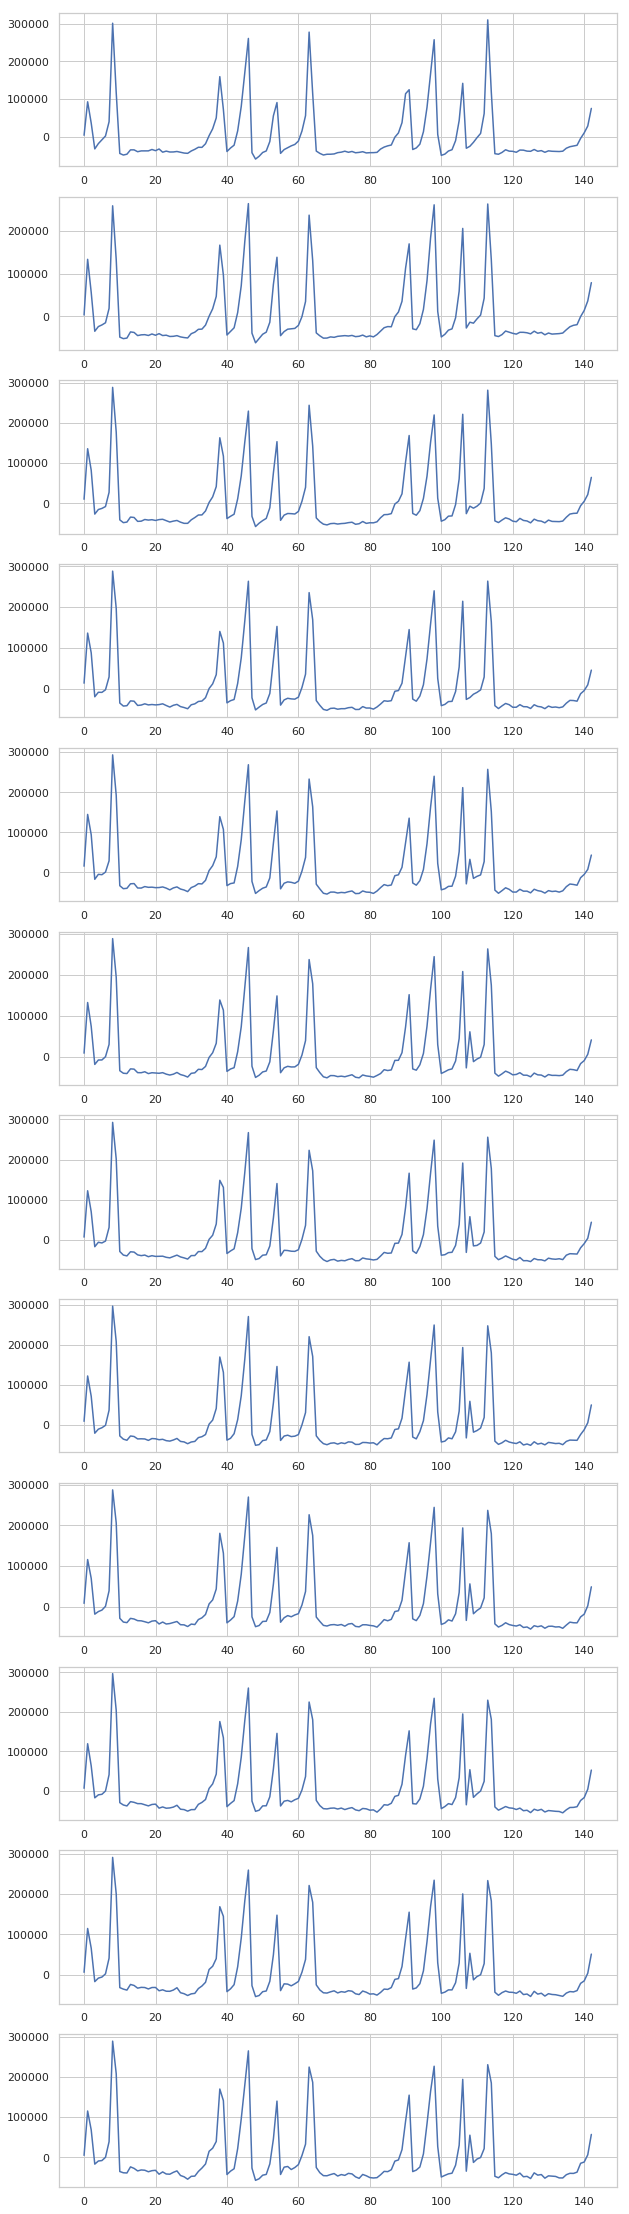

In [78]:
val = 0
plt.figure(figsize=(10, 40))
for i in range(12):
    plt.subplot(12,1,i+1)
    val += df_low[:, i]
    plt.plot(val)
plt.show()

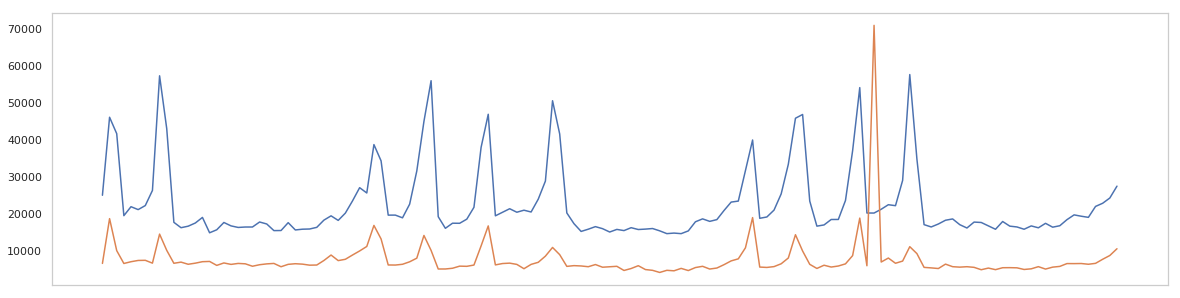

In [48]:
plt.figure(figsize=(20, 5))

plt.plot(df_pivot.loc[:, 1])
plt.plot(df_pivot.loc[:, 43])
plt.grid(False)
plt.xticks([])
plt.show()

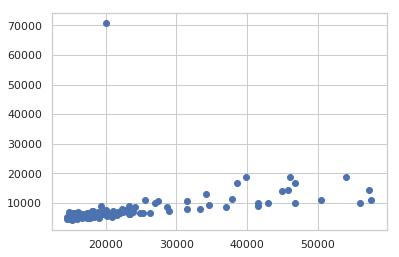

In [50]:
plt.plot()
plt.show()

---

In [92]:
# 1번 store의 경우 components 조금씩 다 가지고 있기 때문에 smoothing 되었음
pca.components_[:, 0]

array([ 0.12689497,  0.17196753,  0.13571706,  0.05991916,  0.0680389 ,
       -0.18308997, -0.19601873, -0.12726943,  0.0288241 ,  0.05027343,
       -0.06786494, -0.09353392])

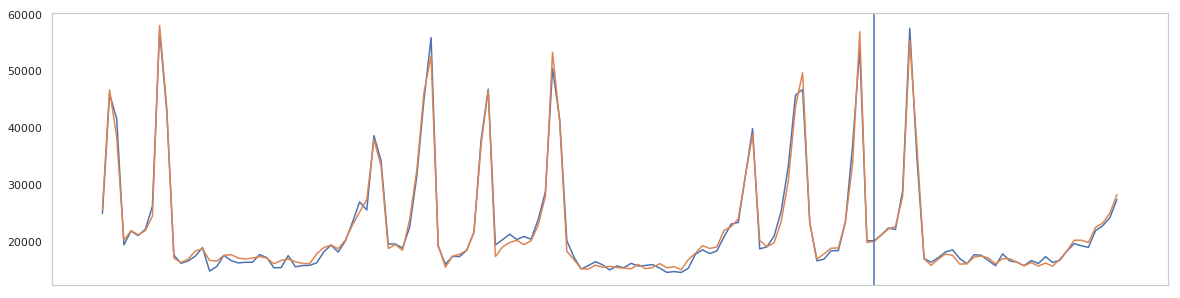

In [76]:
plt.figure(figsize=(20, 5))
plt.plot(df_pivot.loc[:, 1].values)
plt.plot(df_inverse[:, 0])
plt.axvline(108)
plt.grid(False)
plt.xticks([])
plt.show()

In [88]:
# 43번 store의 경우, 5번째 component가 살아남았기 때문에 inverse했을 때 크게 달라지지 않았다
## 반면 12개 component가 굉장히 작은 store은 변화가 클 것이다
pca.components_[:, -3]

array([ 0.02703869,  0.1391074 ,  0.07213626, -0.20086736,  0.87425516,
        0.39159306, -0.01436567,  0.06750858, -0.04775563, -0.03811228,
       -0.02735458,  0.03598845])

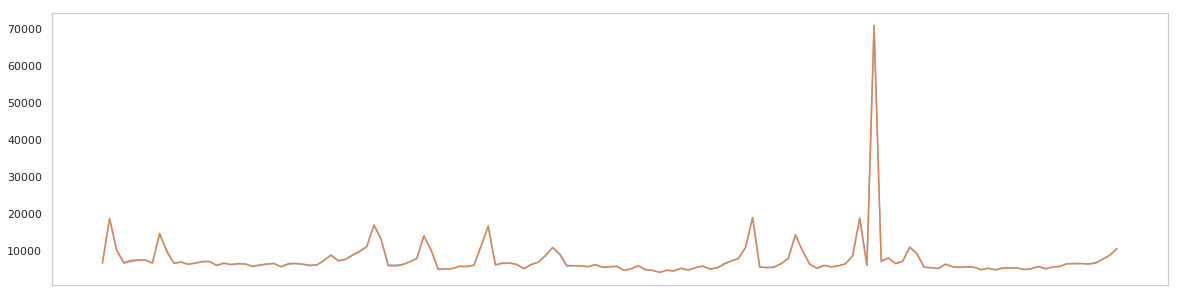

In [69]:
plt.figure(figsize=(20, 5))
plt.plot(df_pivot.loc[:, 43].values, alpha=0.5)
plt.plot(df_inverse[:, -3])
plt.grid(False)
plt.xticks([])
plt.show()

In [185]:
# components 성분 가장 작은 Store는 무엇?
val = 100
for i in range(45):
    if val > np.sum(abs(pca.components_[:, i])):
        val = min(val, np.sum(abs(pca.components_[:, i])))
        print(i)

0
2
4
6
8
32
35


In [193]:
df['Store'].unique()[32]

33

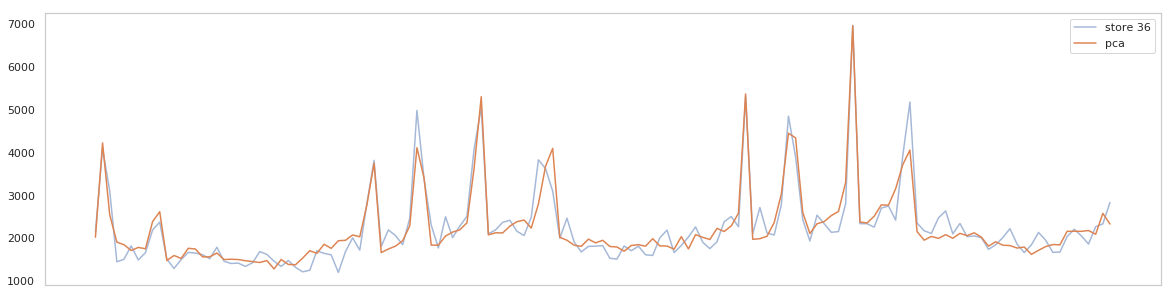

In [192]:
plt.figure(figsize=(20, 5))
plt.plot(df_pivot.loc[:, 36], alpha=0.5, label='store 36')
plt.plot(df_inverse.loc[:, 36], label='pca')
plt.grid(False)
plt.xticks([])
plt.legend()
plt.show()

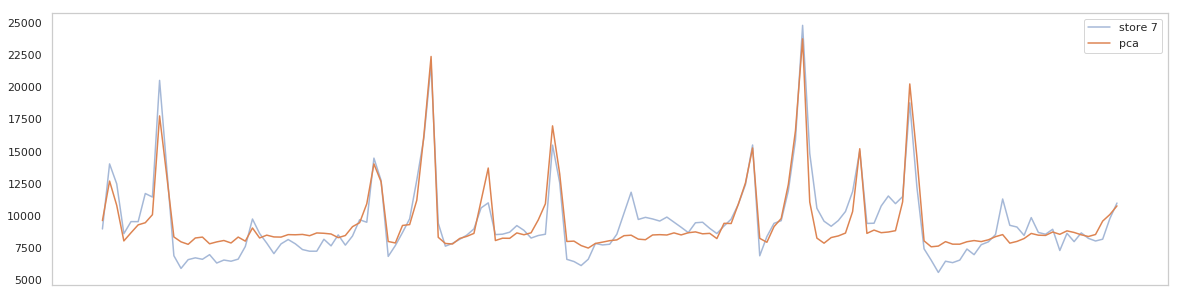

In [195]:
plt.figure(figsize=(20, 5))
plt.plot(df_pivot.loc[:, 7], alpha=0.5, label='store 7')
plt.plot(df_inverse.loc[:, 7], label='pca')
plt.grid(False)
plt.xticks([])
plt.legend()
plt.show()

In [149]:
df_pivot = df_pivot.fillna(0)
idx = df_pivot.index
col = df_pivot.columns
## pca
#pca = PCA(n_components=12)
#df_low = pca.fit_transform(df_pivot.fillna(0))
#df_inverse = pca.inverse_transform(df_low)
df_inverse = pd.DataFrame(df_inverse, columns=col, index=idx)

split_num = int(143*0.9)
split_idx = idx[split_num]

# original
ts_original, ts_test = df_pivot.loc[:split_idx, 7], df_pivot.loc[split_idx:, 7]
# PCA
ts_pca = df_inverse.loc[:split_idx, 7]

In [153]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from dateutil.relativedelta import relativedelta

#decom_obj = seasonal_decompose(ts_original, freq=52)
decom_obj = seasonal_decompose(ts_pca, freq=52)
seasonality = decom_obj.seasonal

#seasonal_adj = ts_original - seasonality
seasonal_adj = ts_pca - seasonality

fcst_period = 15
res = ExponentialSmoothing(seasonal_adj, seasonal='add', seasonal_periods=52, freq='W-FRI').fit(optimized=True, remove_bias=True)
fcst = res.forecast(fcst_period)

# re-seasonalize
def reseasonlize(row):
    idx = row['index'] - relativedelta(weeks=52)
    if idx in seasonality.index:
        val = seasonality.loc[idx] + row[0]
    else:
        idx = row['index'] - relativedelta(weeks=52*2)
        val = seasonality.loc[idx] + row[0]
    return val

re_seasonal_fcst = fcst.reset_index().apply(reseasonlize, axis=1)
re_seasonal_fcst.index = fcst.index

#ori_fcst = re_seasonal_fcst
pca_fcst = re_seasonal_fcst

def reseasonlize2(row):
    idx = row['index']
    val = seasonality.loc[idx] + row[0]
    return val
re_pred = res.fittedvalues.reset_index().rename(columns={'Date':'index'}).apply(reseasonlize2, axis=1)
re_pred.index = res.fittedvalues.index

#ori_fitted = re_pred
pca_fitted = re_pred

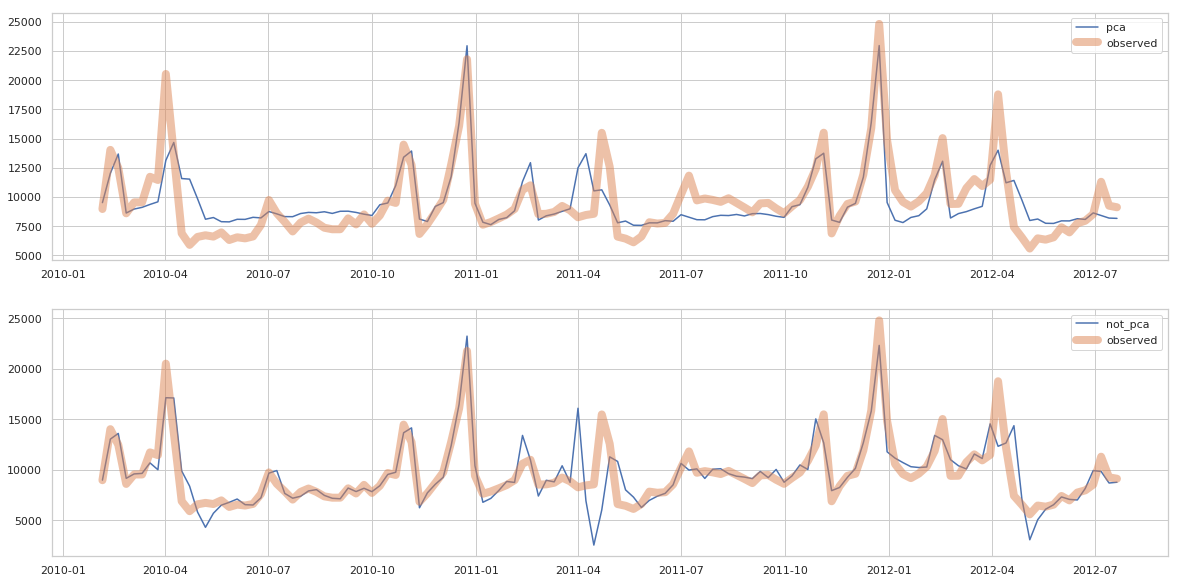

In [207]:
plt.figure(figsize=(20, 10))

plt.subplot(211)
plt.plot(pca_fitted, label='pca')
plt.plot(ts_original, label='observed', linewidth=8, alpha=0.5)
plt.legend()

plt.subplot(212)
plt.plot(ori_fitted, label='not_pca')
plt.plot(ts_original, label='observed', linewidth=8, alpha=0.5)
plt.legend()

plt.show()

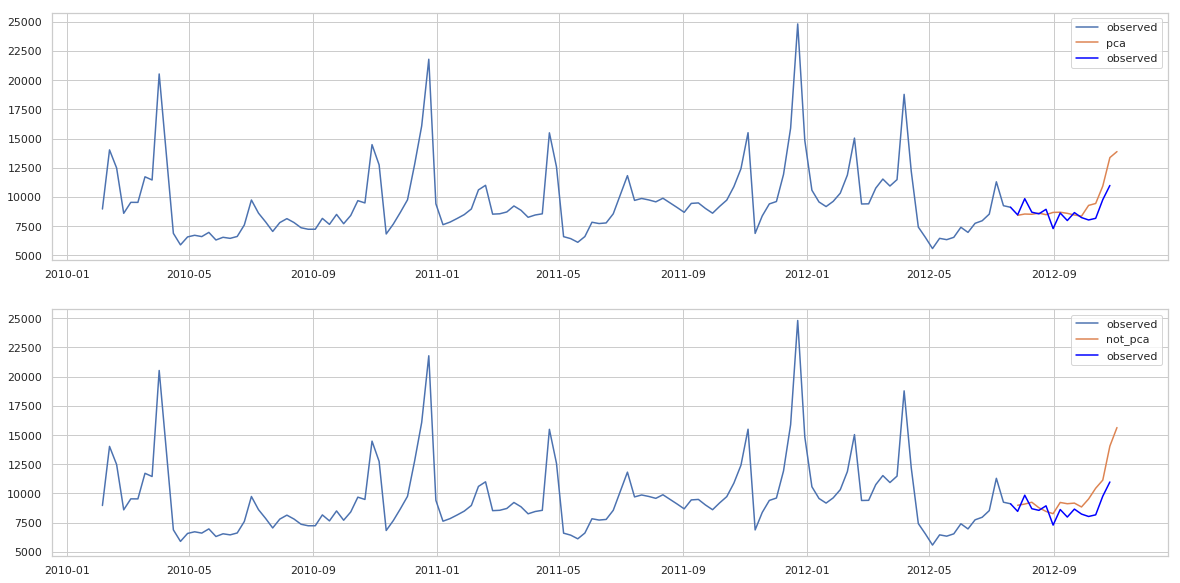

In [209]:
plt.figure(figsize=(20, 10))

plt.subplot(211)
plt.plot(ts_original, label='observed')
plt.plot(pca_fcst, label='pca')
plt.plot(ts_test, color='blue', label='observed')
plt.legend()

plt.subplot(212)
plt.plot(ts_original, label='observed')
plt.plot(ori_fcst, label='not_pca')
plt.plot(ts_test, color='blue', label='observed')
plt.legend()

plt.show()

In [169]:
from sklearn.metrics import mean_squared_error
print('pca:', np.sqrt(mean_squared_error(ts_test, pca_fcst)))
print('original:', np.sqrt(mean_squared_error(ts_test, ori_fcst)))

pca: 1562.2841607197672
original: 2049.296018780097


In [3]:
c = train['Dept'] == 1
c2 = train['Store'] == 1

In [4]:
train[c&c2]['Week']

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


# PCA: Store
- 강동지점은 모든 dept가 1월~3월에 잘팔리고, 4월~5월에 안 팔린다(판매 추이가 같다) -> 말이 안됨

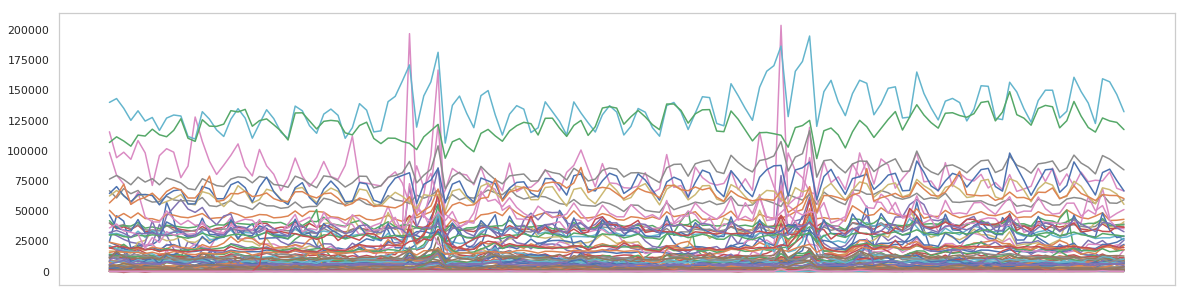

In [210]:
c = df['Store'] == 1
df_pivot = df[c].pivot(index='Date', columns='Dept', values='Weekly_Sales').fillna(0)

plt.figure(figsize=(20, 5))
plt.plot(df_pivot)
plt.grid(False)
plt.xticks([])
plt.show()

[0.3978626  0.54898138 0.65240328 0.7330194  0.79777178 0.83959321
 0.87240037 0.89789552 0.91833032 0.93424545 0.94557562 0.95594272]


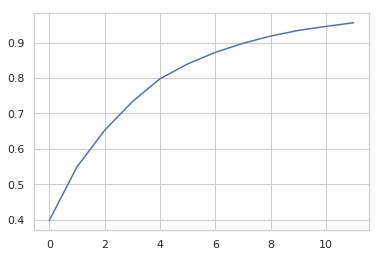

In [218]:
# component1이 가장 강하다 = 분산을 가장 잘 설명한다 = 대표적 패턴이다
df_low = pca.fit_transform(df_pivot)
df_inverse = pca.inverse_transform(df_low)
df_pivot = df_pivot.fillna(0)
idx = df_pivot.index
col = df_pivot.columns
df_inverse = pd.DataFrame(df_inverse, columns=col, index=idx)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_))
plt.show()

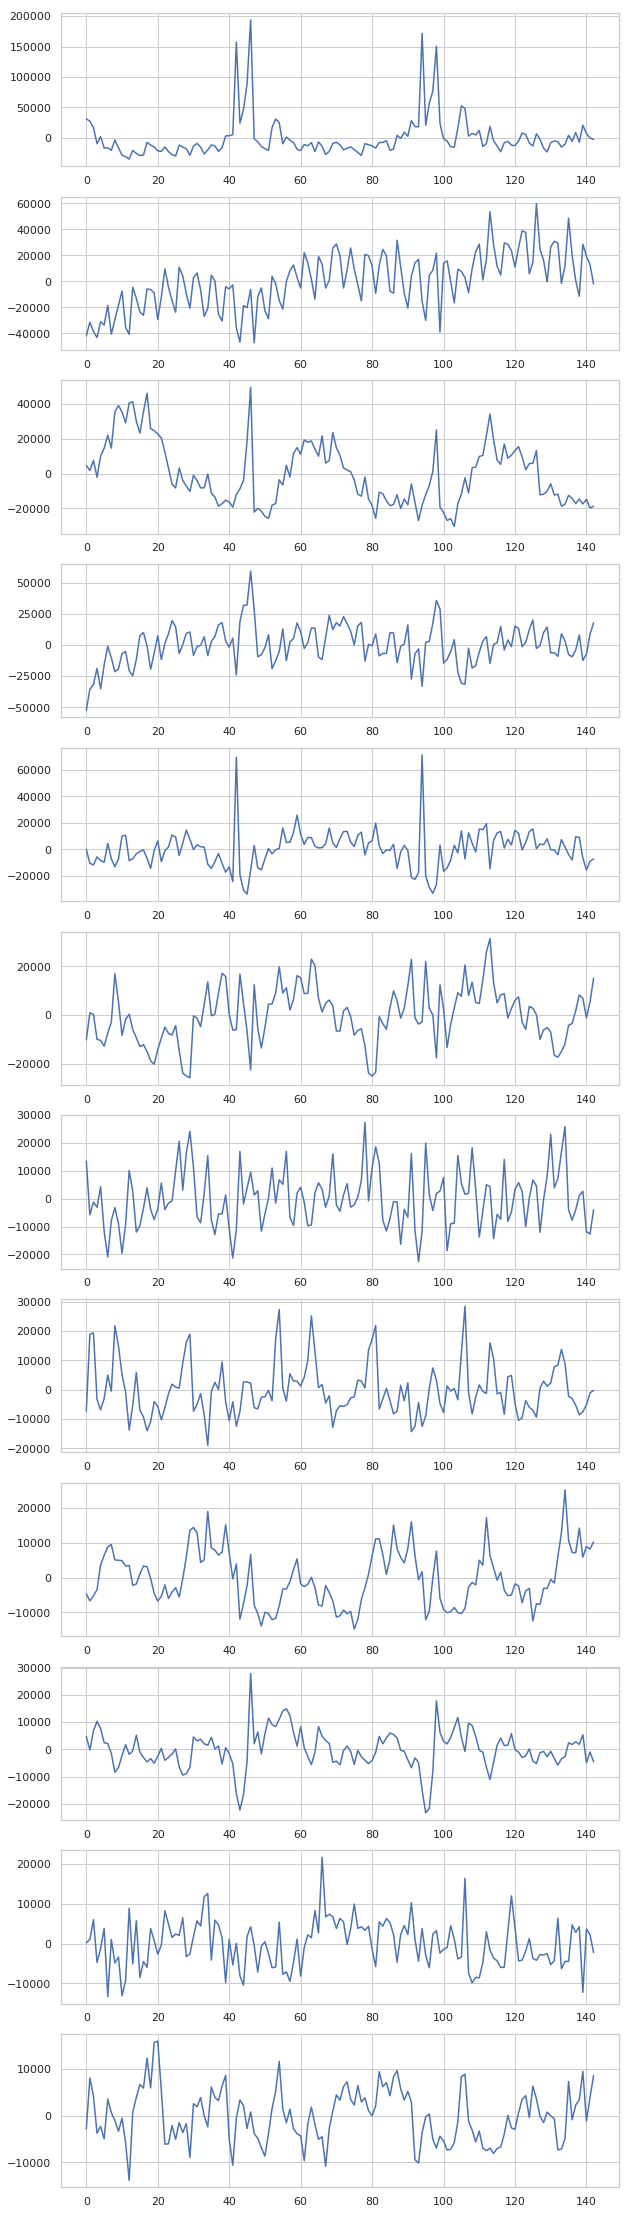

In [215]:
plt.figure(figsize=(10, 40))
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(df_low[:, i])
plt.show()

In [241]:
# components 성분 가장 작은 Store는 무엇?
val = 100
for i in range(77):
    if val > np.sum(abs(pca.components_[:, i])):
        val = min(val, np.sum(abs(pca.components_[:, i])))
        print(i)

0
1
3
5
11
17
26
41
59


In [224]:
df['Dept'].unique()[59]

78

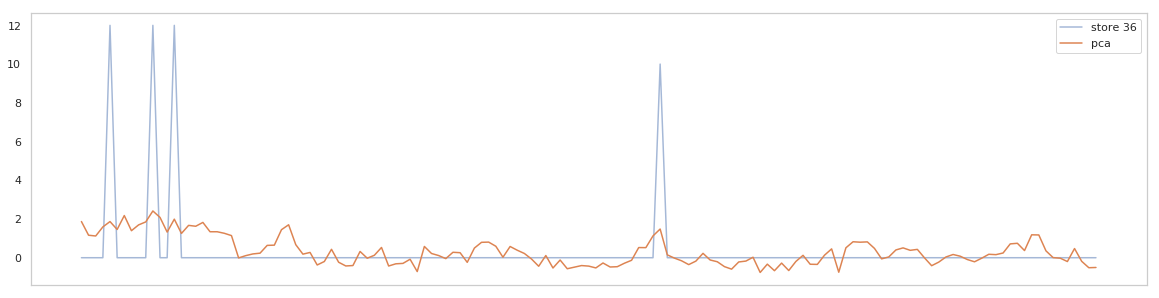

In [225]:
plt.figure(figsize=(20, 5))
plt.plot(df_pivot.loc[:, 78], alpha=0.5, label='store 36')
plt.plot(df_inverse.loc[:, 78], label='pca')
plt.grid(False)
plt.xticks([])
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_pivot.loc[:, 36], alpha=0.5, label='store 36')
plt.plot(df_inverse.loc[:, 36], label='pca')
plt.grid(False)
plt.xticks([])
plt.legend()
plt.show()